# Hydration Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,8]

Importing the file containing the PBAs with water molecules:

In [2]:
# with open('pba_w_APR.json', 'r') as file :
#   pba_json = file.read()

In [3]:
# print(pba_json[:1000])

In [4]:
from monty.serialization import loadfn

In [5]:
data_1 = loadfn('pba_w_APR.json')

In [6]:
# data_1[0]

In [7]:
import pymatgen as mg
from pymatgen.entries.computed_entries import ComputedEntry

In [8]:
pba_entries = []
for i in range((len(data_1))):
    #Creating pymatgen entry:
    entry = ComputedEntry(composition=data_1[i]['input']['structure'].composition,
                              energy=data_1[i]['output']['energy'],
                              parameters = {"nelect": data_1[i]['input']['parameters']['NELECT'],
                                            "hubbards": data_1[i]['input']['hubbards'],
                                            "potcar_spec": data_1[i]['input']['potcar_spec'],
                                            "is_hubbard": data_1[i]['input']['is_hubbard']})
    
#     if 'H' in entry.composition or 'O' in entry.composition: #Filtering out structures with hydrogen or oxygen
#         pba_entries.append('')
    if entry.composition.as_dict()['C'] != 24 or entry.composition.as_dict()['N'] != 24:
        #Filtering out structures that don't have 24 Cs or 24 Ns - these are also not PBAs
        pba_entries.append('')
    else:
        pba_entries.append(entry)

In [9]:
pba_entries[0]

ComputedEntry None - Ca4 Fe4 Co4 C24 N24
Energy = -476.8671
Correction = 0.0000
Parameters:
nelect = 348.0
hubbards = {}
potcar_spec = [{'titel': 'PAW_PBE Ca_sv 06Sep2000', 'hash': 'eb006721e214c04b3c13146e81b3a27d'}, {'titel': 'PAW_PBE Fe_pv 06Sep2000', 'hash': '5963411539032ec3298fa675a32c5e64'}, {'titel': 'PAW_PBE Co 06Sep2000', 'hash': 'b169bca4e137294d2ab3df8cbdd09083'}, {'titel': 'PAW_PBE C 08Apr2002', 'hash': 'c0a8167dbb174fe492a3db7f5006c0f8'}, {'titel': 'PAW_PBE N 08Apr2002', 'hash': 'b98fd027ddebc67da4063ff2cabbc04b'}]
is_hubbard = False
Data:

In [10]:
len(pba_entries)

3783

In [11]:
pba_h2o = []
for i in range(len(pba_entries)):
    if pba_entries[i] == '':
        continue
    if 'O' in pba_entries[i].composition.as_dict().keys():
        pba_h2o.append(pba_entries[i])
#         print(i)
# pba_h2o[0]

In [12]:
len(pba_h2o)

329

From this, we see that there are 329 PBAs with water molecules.

In previous work, we found that the relationship between # water molecules and (Total PBA energy - energy of water molecules) is linear. We will use this to calculate the e_above_hull for hydrated molecules, which can then be used to find the stabilization effect of intercalated water.

In [13]:
from pymatgen import MPRester
mpr = MPRester(api_key='clRGHmBDgp1xt9zA')
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
mpc = MaterialsProjectCompatibility()
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
import pymatgen.analysis.local_env as localenv
crys = localenv.CrystalNN()

In [14]:
def my_crystal_nn(struct):
    '''
    Returns the A, P, and R atoms of a PBA in a list [A,P,R].
    struct is data in the form data_1[i]['input']['structure'] and must be a PBA.
    Uses pymatgen's CrystalNN method.
    '''
    A_atom_nn,P_atom_nn, R_atom_nn = '','','' #Initializing A, P, and R atoms
    for j in range(len(struct)): #Looping through all of the elements in the PBA
        atom = struct[j].as_dict()['species'][0]['element']
        
        if atom == 'C' and len(R_atom_nn)==0:
            nn_objs = crys.get_nn_info(struct, j) #getting the nearest neighbors for atom, which is the jth atom in struct
            for k in range(len(nn_objs)):
                nn = nn_objs[k]['site'].as_dict()['species'][0]['element']
                if nn != 'N':
                    R_atom_nn = nn
                    break
                    
        elif atom == 'N' and len(P_atom_nn)==0:
            nn_objs = crys.get_nn_info(struct, j) #getting the nearest neighbors for atom, which is the jth atom in struct
            for k in range(len(nn_objs)):
                nn = nn_objs[k]['site'].as_dict()['species'][0]['element']
                if nn != 'C':
                    P_atom_nn = nn
                    break
                    
    for j in struct.composition.as_dict().keys():
        if j not in [P_atom_nn,R_atom_nn,'C','N','H','O']:
            A_atom_nn = j
            break
    return [A_atom_nn,P_atom_nn,R_atom_nn]

### Main Loop
Here, we extract the total molecule energy, A/P/R atoms, # A atoms, and # water molecules for each PBA into a dataframe.

#### Actual main loop

In [15]:
# pba_e_hull_df = pd.DataFrame(index=range(len(data_1)),columns=['Composition','Formula','Energy','P_atom','R_atom','n_H2O'])
# for i in range(len(pba_entries)):
#     try:
#         if i%250 == 0:
#             print(str(i) + 'th iteration') #Just to make it easier to keep track of how the algorithm is running
            
#         struct=data_1[i]['input']['structure']
#         pba_entry = pba_entries[i]
#         if type(pba_entry) == str: #If the entry is string, then it was filtered out and we didn't create a pymatgen entry for it.
#             continue
#         comp = pba_entry.composition

#         h2o_flag = False #Setting up a flag to tell whether this PBA is hydrated
#         if 'O' in comp.as_dict().keys():
#             h2o_flag = True

#         comp_dict = {'structure': my_crystal_nn(struct)} #Using my custom CrystalNN function to get the A,P,R
        
#         if comp_dict['structure'][0] != '': #if the A atom field is not empty:
#             continue #for this analysis, we're skipping all PBAs that contain A atoms.
#             #This will leave us only with the PBAs that either have H2Os or have zero A atoms and zero H2O.

#         repeat_flag = False #initializing flag to indicate whether to move on to next structure because this is a repeat
#         for prev in range(i): #loop through previously created entriaes to check if there are for the exact same PBA:
#             if (#(comp_dict['structure'][0] == pba_e_hull_df.iloc[prev,3]) & #Checks if A atom is same
#                 (comp_dict['structure'][1] == pba_e_hull_df.loc[prev,'P_atom']) & #Checks P atom
#                 (comp_dict['structure'][2] == pba_e_hull_df.loc[prev,'R_atom']) & #Checks R atom
#                 #(comp.as_dict()[comp_dict['structure'][0]] == pba_e_hull_df.loc[prev,'n_A']) & #Checks # of A atoms
#                 (comp.as_dict()['O'] == pba_e_hull_df.loc[prev,'n_H2O'])): #checks # water molecules
#                 repeat_flag = True
#                 break
#         if repeat_flag:
#             continue

#         #Making list of other PBAs from list pba_entries with the same composition:
#         same_comps = []
#         for j in range(i, len(pba_entries)):
#             if type(pba_entries[j]) is str: #skip empty entries
#                 continue
#             if pba_entries[j].composition == comp:
#                 same_comps.append([pba_entries[j],j])

#         for k in range(len(same_comps)):
#             comp_dict[same_comps[k][1]] = my_crystal_nn(data_1[same_comps[k][1]]['input']['structure'])
#         #comp_dict is now a dictionary of all structures in data_1 with the same composition. The dictionary index
#         #is the index of the structure in data_1, and the value is a list of the [A,P,R] atom identities.

#         for k in range(len(same_comps)):
#             if comp_dict[same_comps[k][1]][1] != comp_dict['structure'][1] or comp_dict[same_comps[k][1]][2] != comp_dict['structure'][2]:
#                 del comp_dict[same_comps[k][1]]
#         #comp_dict is now a dictionary of the structures in data_1 with same composition AND same A,P,R atoms

#         #We also want to delete the structures with different APR atoms dictionary from the same_comp list.
#         same_comps_and_APR = []
#         for k in range(len(same_comps)):
#             if same_comps[k][1] in comp_dict.keys(): #check if the index for that structure is in the comp_dict keys
#                 same_comps_and_APR.append(same_comps[k][0])
#         #same_comps_and_APR is now a list of the pymatgen entries with the same composition and APR atoms

# #         #Accessing MP data for structures with the any of the same atoms:
# #         comp_atoms = comp.as_dict().keys()
# #         entries = mpr.get_entries_in_chemsys(comp_atoms)
# #         #Adding our pbas to this list of pymatgen entries:
# #         entries = entries + same_comps_and_APR

# #         #Applying correction using MPRester:
# #         corrected_entries = mpc.process_entries(entries)

# #         #If PBA is hydrated (conatains at least one H2O), the corrected_entries step will get rid of the PBAs.
# #         #Therefore, we add the pba entries back into the corrected_entries list here:
# #         if h2o_flag:
# #             corrected_entries = corrected_entries + same_comps_and_APR

# #         #Making phase diagram:
# #         phase_d = PhaseDiagram(corrected_entries)

# #         #Looping through the PBA structures to find the lowest energy above hull value:
# #         e_above_hull_list = []
# #         for k in range(1,len(same_comps_and_APR)+1):
# #             e_above_hull_list.append(phase_d.get_e_above_hull(corrected_entries[-k]))
# #         e_above_hull = min(e_above_hull_list)

#         #Adding the values known so far to the main df:
#         pba_e_hull_df.loc[i, 'Composition'] = comp
#         pba_e_hull_df.loc[i, 'Formula'] = comp.formula
#         pba_e_hull_df.loc[i, 'Energy'] = pba_entry.energy
# #         pba_e_hull_df.loc[i, 'e_above_hull'] = e_above_hull

#         #Adding the A, P, and R atoms to main df:
# #         pba_e_hull_df.loc[i, 'A_atom'] = comp_dict['structure'][0]
#         pba_e_hull_df.loc[i, 'P_atom'] = comp_dict['structure'][1]
#         pba_e_hull_df.loc[i, 'R_atom'] = comp_dict['structure'][2]
# #         pba_e_hull_df.loc[i, 'n_A'] = comp.as_dict()[comp_dict['structure'][0]]
#         if h2o_flag:
#             pba_e_hull_df.loc[i, 'n_H2O'] = comp.as_dict()['O']
#         else:
#             pba_e_hull_df.loc[i, 'n_H2O'] = 0
        
#     except:
#         print('Error on ' + str(i))
#         continue

In [16]:
# pba_h2o = pba_e_hull_df.dropna(axis = 0, how = 'all')
# pba_h2o.head()

In [17]:
# #Saving to file as pba_h2o.csv
# pba_h2o.to_csv('pba_h2o.csv')

In [18]:
pba_h2o = pd.read_csv('pba_h2o.csv')
pba_h2o.drop('Unnamed: 0', axis = 1, inplace = True)

In [19]:
len(pba_h2o)

208

In [20]:
len(pba_h2o[pba_h2o['n_H2O'] > 0])

172

From this, we see that there are 172 unique structures that contain water molecules, plus another 36 structures that have no water molecules or A atoms.

## Analyzing hydration data
We will use the e_hull values for the given structures to extrapolate the e_hull values for each PBA at 100% hydration. Using this, we will be able to determine what fraction of the PBAs are stable at 100% hydration.

Note that others have found in previous analyses that e_hull values have a very strong linear relationship with # of water molecules, so extrapolating e_hull values at 100% hydration is a safe method of determining stability.

In [21]:
pba_h2o.head()

,Composition,Formula,Energy,P_atom,R_atom,n_H2O
0,Mn4 Fe4 H2 C24 N24 O1,Mn4 Fe4 H2 C24 N24 O1,-492.568388,Mn,Fe,1.0
1,Mn4 Fe4 H8 C24 N24 O4,Mn4 Fe4 H8 C24 N24 O4,-535.239268,Mn,Fe,4.0
2,Mn4 Fe4 H6 C24 N24 O3,Mn4 Fe4 H6 C24 N24 O3,-520.960972,Mn,Fe,3.0
3,Mn4 Fe4 H8 C24 N24 O4,Mn4 Fe4 H8 C24 N24 O4,-530.713359,Fe,Mn,4.0
4,Cr8 H8 C24 N24 O4,Cr8 H8 C24 N24 O4,-542.780128,Cr,Cr,4.0


In [22]:
p_atoms = pba_h2o['P_atom'].unique()
p_atoms

array(['Mn', 'Fe', 'Cr', 'Co', 'Zn', 'V'], dtype=object)

In [23]:
r_atoms = pba_h2o['R_atom'].unique()
r_atoms

array(['Fe', 'Mn', 'Cr', 'Os', 'Co', 'V'], dtype=object)

### Walking through the analysis for one PBA:

In [24]:
mn_fe = pba_h2o[(pba_h2o['P_atom'] == 'Mn') & (pba_h2o['R_atom'] == 'Fe')]
mn_fe = mn_fe.sort_values('n_H2O')
mn_fe

,Composition,Formula,Energy,P_atom,R_atom,n_H2O
193,Mn4 Fe4 C24 N24,Mn4 Fe4 C24 N24,-478.355188,Mn,Fe,0.0
0,Mn4 Fe4 H2 C24 N24 O1,Mn4 Fe4 H2 C24 N24 O1,-492.568388,Mn,Fe,1.0
6,Mn4 Fe4 H4 C24 N24 O2,Mn4 Fe4 H4 C24 N24 O2,-506.770166,Mn,Fe,2.0
2,Mn4 Fe4 H6 C24 N24 O3,Mn4 Fe4 H6 C24 N24 O3,-520.960972,Mn,Fe,3.0
1,Mn4 Fe4 H8 C24 N24 O4,Mn4 Fe4 H8 C24 N24 O4,-535.239268,Mn,Fe,4.0
11,Mn4 Fe4 H10 C24 N24 O5,Mn4 Fe4 H10 C24 N24 O5,-549.426479,Mn,Fe,5.0
8,Mn4 Fe4 H12 C24 N24 O6,Mn4 Fe4 H12 C24 N24 O6,-563.621715,Mn,Fe,6.0
10,Mn4 Fe4 H14 C24 N24 O7,Mn4 Fe4 H14 C24 N24 O7,-577.850115,Mn,Fe,7.0
14,Mn4 Fe4 H16 C24 N24 O8,Mn4 Fe4 H16 C24 N24 O8,-592.008134,Mn,Fe,8.0


Text(0.5,1,'Total Energy vs number of water molecules, P = Mn and R = Fe')

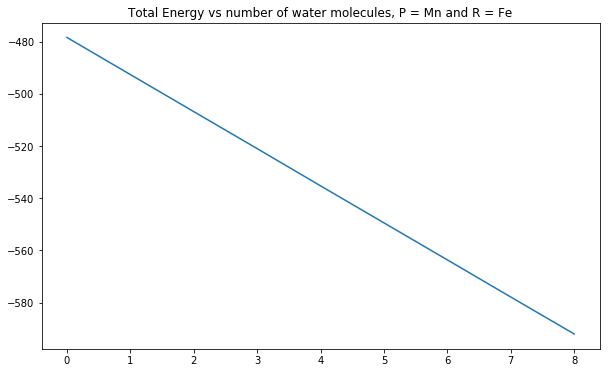

In [25]:
plt.rcParams['figure.figsize'] = [10,6]
plt.plot(mn_fe['n_H2O'],mn_fe['Energy'])
plt.title('Total Energy vs number of water molecules, P = Mn and R = Fe')

The first step to finding hydration energy is finding slope of this line:

In [26]:
slope = (mn_fe[mn_fe['n_H2O'] == 8]['Energy'].values[0] - mn_fe[mn_fe['n_H2O'] == 0]['Energy'].values[0])/8
slope #this is the hydration_energy

-14.20661818125

Next, we add in corrections for the formation energy of water and for the entropy of water:

In [27]:
h2o_formation_energy = -14.21
h2o_entropy = 0.5
corrected_slope = slope - h2o_formation_energy - h2o_entropy
corrected_slope #in eV

-0.4966181812499997

Now that we have the corrected_slope (which is the hydration energy), we can apply it to find the e_above_hull of hydrated PBAs:

In [28]:
pba_entries[2]

ComputedEntry None - Ca4 Mn4 Fe4 C24 N24
Energy = -491.4683
Correction = 0.0000
Parameters:
nelect = 364.0
hubbards = {}
potcar_spec = [{'titel': 'PAW_PBE Ca_sv 06Sep2000', 'hash': 'eb006721e214c04b3c13146e81b3a27d'}, {'titel': 'PAW_PBE Mn_pv 07Sep2000', 'hash': 'fa52f891f234d49bb4cb5ea96aae8f98'}, {'titel': 'PAW_PBE Fe_pv 06Sep2000', 'hash': '5963411539032ec3298fa675a32c5e64'}, {'titel': 'PAW_PBE C 08Apr2002', 'hash': 'c0a8167dbb174fe492a3db7f5006c0f8'}, {'titel': 'PAW_PBE N 08Apr2002', 'hash': 'b98fd027ddebc67da4063ff2cabbc04b'}]
is_hubbard = False
Data:

In [29]:
comp = pba_entries[2].composition

In [30]:
comp_atoms = comp.as_dict().keys()
comp_atoms

dict_keys(['Ca', 'Mn', 'Fe', 'C', 'N'])

In [31]:
entries = mpr.get_entries_in_chemsys(comp_atoms)
corrected_entries = mpc.process_entries(entries)
phase_d = PhaseDiagram(corrected_entries)

In [32]:
e_hull = phase_d.get_e_above_hull(pba_entries[2])
e_hull #of Ca4 Mn4 Fe4 C24 N24 PBA, uncorrected (this is in eV/atom)

0.3826480011271123

In [33]:
comp.num_atoms

60.0

In [34]:
e_hull_total = e_hull*60
e_hull_total #This is the a_above_hull of the total PBA in eV

22.958880067626737

In [35]:
e_hull_total_corrected = e_hull_total + corrected_slope*8
e_hull_total_corrected #Corrected e_above_hull for total hydrated PBA in eV

18.98593461762674

In [36]:
e_hull_corrected = e_hull_total_corrected/60
e_hull_corrected #Corrected e_above_hull in eV/atom

0.3164322436271123

Now that we know our method works for finding the e_above_hull of the hydrated PBAs, we will apply this method for all of the PBAs in the original file. 

The first step is to calculate the hydration energy for all of the P and R systems for which hydration data is available:

In [37]:
# Eventually, change this loop so it creates a df of corrected_slopes with fields for P and R atom.
e_h2o = -14.21 #energy of formation of water
s_h2o = 0.5 #entropy of formation water
e_hydration_df = pd.DataFrame(index=range(36),columns=['P_atom','R_atom','e_hydration'])
counter = 0
for p in p_atoms:
    for r in r_atoms:
        e_hydration_df.loc[counter,'P_atom'] = p
        e_hydration_df.loc[counter,'R_atom'] = r
        p_r = pba_h2o[(pba_h2o['P_atom'] == p) & (pba_h2o['R_atom'] == r)] #p_r is df of the hydrated PBAs with given p and r
        max_h2o = max(p_r['n_H2O'])
        min_h2o = min(p_r['n_H2O'])
        if (max_h2o - min_h2o) != 0:
            slope = (p_r[p_r['n_H2O'] == max_h2o]['Energy'].values[0] - p_r[p_r['n_H2O'] == min_h2o]['Energy'].values[0])/(max_h2o - min_h2o)
            corrected_slope = slope - e_h2o - s_h2o
            e_hydration_df.loc[counter,'e_hydration'] = corrected_slope
         #Systems without enough values to make a line won't have an entry in the e_hydration field
        else:
            print(p,r)
        counter += 1

Mn Co
Fe Co
Cr Os
Co V
Zn Fe
Zn Co
Zn V
V Co


In [38]:
e_hydration_df.head()

,P_atom,R_atom,e_hydration
0,Mn,Fe,-0.496618
1,Mn,Mn,-0.513344
2,Mn,Cr,-0.533875
3,Mn,Os,-0.534899
4,Mn,Co,NaN


Next, we loop through all of the PBAs in the full df (this df was the one created in notebook 02). We access the previously calculated e_above_hull from that df and apply our hydration correction method to find the e_above_hull of each PBA at 25%, 50%, and 100% hydration.

In [124]:
pba_e_hull_df = pd.read_csv('pba_e_hull_df.csv')
pba_e_hull_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [125]:
pba_e_hull_df['25%'] = np.nan
pba_e_hull_df['50%'] = np.nan
pba_e_hull_df['100%'] = np.nan

In [126]:
pba_e_hull_df = pba_e_hull_df.dropna(how = 'all')

In [129]:
for i in pba_e_hull_df.index:
    try:
        p = pba_e_hull_df.loc[i,'P_atom']
        r = pba_e_hull_df.loc[i,'R_atom']
        e_hydration = e_hydration_df[(e_hydration_df['P_atom'] == p) & (e_hydration_df['R_atom'] == r)]['e_hydration'].values[0]
        if np.isnan(e_hydration):
            continue
        else:
            n_atoms = 56 + pba_e_hull_df.loc[i,'n_A']
            e_hull_total = n_atoms*pba_e_hull_df.loc[i,'e_above_hull']
            pba_e_hull_df.loc[i,'25%'] = (e_hull_total + e_hydration*2)/n_atoms
            pba_e_hull_df.loc[i,'50%'] = (e_hull_total + e_hydration*4)/n_atoms
            pba_e_hull_df.loc[i,'100%'] = (e_hull_total + e_hydration*8)/n_atoms
    except:
        print(i)

In [132]:
pba_e_hull_df = pba_e_hull_df.dropna(subset = ['25%']) #gets rid of rows with nan in 25% column - these didn't have enough hydration data
pba_e_hull_df.head()

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,25%,50%,100%
2,Ca4 Mn4 Fe4 C24 N24,Ca4 Mn4 Fe4 C24 N24,0.382632,Ca,Fe,Mn,4.0,0.365615,0.348599,0.314565
3,Ca4 Mn4 Os4 C24 N24,Ca4 Mn4 Os4 C24 N24,0.303914,Ca,Mn,Os,4.0,0.286084,0.268254,0.232594
4,Li4 Cr8 C24 N24,Li4 Cr8 C24 N24,0.315066,Li,Cr,Cr,4.0,0.301748,0.288431,0.261795
6,Sr4 Cr4 Fe4 C24 N24,Sr4 Cr4 Fe4 C24 N24,0.375030,Sr,Fe,Cr,4.0,0.357320,0.339611,0.304193
8,Mg4 Mn4 V4 C24 N24,Mg4 Mn4 V4 C24 N24,0.484794,Mg,V,Mn,4.0,0.463290,0.441786,0.398778


In [144]:
len(pba_e_hull_df)

901

## Analysis

Now that we have all of the hydration data, let's analyze how the hydration affects the PBA's stability.

In [142]:
#First: find if any have e_hull < 0:
pba_e_hull_df[pba_e_hull_df['25%'] < 0]

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,25%,50%,100%
1089,NaN,Rb1 Cr4 Co4 C24 N24,0.017671,Rb,Cr,Co,1.0,-0.000306,-0.018284,-0.054239
1111,NaN,Rb1 V4 Cr4 C24 N24,0.006039,Rb,Cr,V,1.0,-0.013193,-0.032425,-0.070888
1343,NaN,Rb6 Mn4 Fe4 C24 N24,0.007397,Rb,Fe,Mn,6.0,-0.009071,-0.025539,-0.058475


In [135]:
pba_e_hull_df[pba_e_hull_df['50%'] < 0]

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,25%,50%,100%
1022,NaN,Na4 Fe4 Co4 C24 N24,0.026066,Na,Co,Fe,4.0,0.010520,-0.005025,-0.036116
1040,NaN,Rb8 Fe4 Os4 C24 N24,0.021116,Rb,Fe,Os,8.0,0.004493,-0.012131,-0.045377
1050,NaN,Rb8 Zn4 Os4 C24 N24,0.023983,Rb,Zn,Os,8.0,0.005743,-0.012498,-0.048979
1060,NaN,Rb8 Mn4 Os4 C24 N24,0.032078,Rb,Mn,Os,8.0,0.015363,-0.001353,-0.034784
1062,NaN,Rb8 V4 Cr4 C24 N24,0.028448,Rb,V,Cr,8.0,0.009657,-0.009134,-0.046716
1089,NaN,Rb1 Cr4 Co4 C24 N24,0.017671,Rb,Cr,Co,1.0,-0.000306,-0.018284,-0.054239
1111,NaN,Rb1 V4 Cr4 C24 N24,0.006039,Rb,Cr,V,1.0,-0.013193,-0.032425,-0.070888
1343,NaN,Rb6 Mn4 Fe4 C24 N24,0.007397,Rb,Fe,Mn,6.0,-0.009071,-0.025539,-0.058475


In [151]:
pba_e_hull_df[pba_e_hull_df['100%'] < 0]

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,25%,50%,100%
1022,NaN,Na4 Fe4 Co4 C24 N24,0.026066,Na,Co,Fe,4.0,0.010520,-0.005025,-0.036116
1036,NaN,Rb8 V4 Os4 C24 N24,0.046151,Rb,V,Os,8.0,0.029016,0.011880,-0.022391
1040,NaN,Rb8 Fe4 Os4 C24 N24,0.021116,Rb,Fe,Os,8.0,0.004493,-0.012131,-0.045377
1050,NaN,Rb8 Zn4 Os4 C24 N24,0.023983,Rb,Zn,Os,8.0,0.005743,-0.012498,-0.048979
1060,NaN,Rb8 Mn4 Os4 C24 N24,0.032078,Rb,Mn,Os,8.0,0.015363,-0.001353,-0.034784
1061,NaN,Rb8 Mn4 Cr4 C24 N24,0.049707,Rb,Cr,Mn,8.0,0.034162,0.018618,-0.012470
1062,NaN,Rb8 V4 Cr4 C24 N24,0.028448,Rb,V,Cr,8.0,0.009657,-0.009134,-0.046716
1064,NaN,Rb8 Fe8 C24 N24,0.059115,Rb,Fe,Fe,8.0,0.042576,0.026036,-0.007043
1089,NaN,Rb1 Cr4 Co4 C24 N24,0.017671,Rb,Cr,Co,1.0,-0.000306,-0.018284,-0.054239
1102,NaN,Rb7 Fe4 Os4 C24 N24,0.043490,Rb,Fe,Os,7.0,0.026603,0.009715,-0.024059


In [150]:
len(pba_e_hull_df[pba_e_hull_df['100%'] < 0])

23

From this, we can conclude that several of the PBAs were stabilized at various levels of hydration to bring their e_hull below zero, which would indicate that they are very stable when hydrated.

However, let's also check the stability criteria of e_hull < 0.025:

In [143]:
pba_e_hull_df[pba_e_hull_df['e_above_hull'] < 0.025]

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,25%,50%,100%
1040,NaN,Rb8 Fe4 Os4 C24 N24,0.021116,Rb,Fe,Os,8.0,0.004493,-0.012131,-0.045377
1050,NaN,Rb8 Zn4 Os4 C24 N24,0.023983,Rb,Zn,Os,8.0,0.005743,-0.012498,-0.048979
1089,NaN,Rb1 Cr4 Co4 C24 N24,0.017671,Rb,Cr,Co,1.0,-0.000306,-0.018284,-0.054239
1111,NaN,Rb1 V4 Cr4 C24 N24,0.006039,Rb,Cr,V,1.0,-0.013193,-0.032425,-0.070888
1343,NaN,Rb6 Mn4 Fe4 C24 N24,0.007397,Rb,Fe,Mn,6.0,-0.009071,-0.025539,-0.058475


In [137]:
pba_e_hull_df[pba_e_hull_df['25%'] < 0.025]

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,25%,50%,100%
1022,NaN,Na4 Fe4 Co4 C24 N24,0.026066,Na,Co,Fe,4.0,0.010520,-0.005025,-0.036116
1040,NaN,Rb8 Fe4 Os4 C24 N24,0.021116,Rb,Fe,Os,8.0,0.004493,-0.012131,-0.045377
1050,NaN,Rb8 Zn4 Os4 C24 N24,0.023983,Rb,Zn,Os,8.0,0.005743,-0.012498,-0.048979
1060,NaN,Rb8 Mn4 Os4 C24 N24,0.032078,Rb,Mn,Os,8.0,0.015363,-0.001353,-0.034784
1062,NaN,Rb8 V4 Cr4 C24 N24,0.028448,Rb,V,Cr,8.0,0.009657,-0.009134,-0.046716
1089,NaN,Rb1 Cr4 Co4 C24 N24,0.017671,Rb,Cr,Co,1.0,-0.000306,-0.018284,-0.054239
1111,NaN,Rb1 V4 Cr4 C24 N24,0.006039,Rb,Cr,V,1.0,-0.013193,-0.032425,-0.070888
1343,NaN,Rb6 Mn4 Fe4 C24 N24,0.007397,Rb,Fe,Mn,6.0,-0.009071,-0.025539,-0.058475
1996,NaN,Li3 Cr4 Fe4 C24 N24,0.042590,Li,Cr,Fe,3.0,0.023655,0.004720,-0.033150


In [146]:
pba_e_hull_df[pba_e_hull_df['50%'] < 0.025]

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,25%,50%,100%
1022,NaN,Na4 Fe4 Co4 C24 N24,0.026066,Na,Co,Fe,4.0,0.010520,-0.005025,-0.036116
1036,NaN,Rb8 V4 Os4 C24 N24,0.046151,Rb,V,Os,8.0,0.029016,0.011880,-0.022391
1040,NaN,Rb8 Fe4 Os4 C24 N24,0.021116,Rb,Fe,Os,8.0,0.004493,-0.012131,-0.045377
1050,NaN,Rb8 Zn4 Os4 C24 N24,0.023983,Rb,Zn,Os,8.0,0.005743,-0.012498,-0.048979
1060,NaN,Rb8 Mn4 Os4 C24 N24,0.032078,Rb,Mn,Os,8.0,0.015363,-0.001353,-0.034784
1061,NaN,Rb8 Mn4 Cr4 C24 N24,0.049707,Rb,Cr,Mn,8.0,0.034162,0.018618,-0.012470
1062,NaN,Rb8 V4 Cr4 C24 N24,0.028448,Rb,V,Cr,8.0,0.009657,-0.009134,-0.046716
1089,NaN,Rb1 Cr4 Co4 C24 N24,0.017671,Rb,Cr,Co,1.0,-0.000306,-0.018284,-0.054239
1102,NaN,Rb7 Fe4 Os4 C24 N24,0.043490,Rb,Fe,Os,7.0,0.026603,0.009715,-0.024059
1109,NaN,Rb7 Mn4 Os4 C24 N24,0.048870,Rb,Mn,Os,7.0,0.031889,0.014908,-0.019054


In [149]:
len(pba_e_hull_df[pba_e_hull_df['50%'] < 0.025])

18

In [148]:
pba_e_hull_df[pba_e_hull_df['100%'] < 0.025]

,Composition,Formula,e_above_hull,A_atom,P_atom,R_atom,n_A,25%,50%,100%
42,K4 V4 Os4 C24 N24,K4 V4 Os4 C24 N24,0.089735,K,V,Os,4.0,0.071457,0.053179,0.016624
70,K4 Cr4 Fe4 C24 N24,K4 Cr4 Fe4 C24 N24,0.092216,K,Cr,Fe,4.0,0.073596,0.054977,0.017738
181,K2 Mn4 Os4 C24 N24,K2 Mn4 Os4 C24 N24,0.082288,K,Mn,Os,2.0,0.063843,0.045398,0.008508
368,NaN,K2 V4 Os4 C24 N24,0.097547,K,V,Os,2.0,0.078638,0.059730,0.021914
484,NaN,K6 V4 Os4 C24 N24,0.082498,K,V,Os,6.0,0.064810,0.047122,0.011746
616,NaN,K6 Fe4 Os4 C24 N24,0.077375,K,Fe,Os,6.0,0.060216,0.043056,0.008737
736,NaN,K6 Mn4 Os4 C24 N24,0.073170,K,Mn,Os,6.0,0.055915,0.038660,0.004151
1022,NaN,Na4 Fe4 Co4 C24 N24,0.026066,Na,Co,Fe,4.0,0.010520,-0.005025,-0.036116
1036,NaN,Rb8 V4 Os4 C24 N24,0.046151,Rb,V,Os,8.0,0.029016,0.011880,-0.022391
1040,NaN,Rb8 Fe4 Os4 C24 N24,0.021116,Rb,Fe,Os,8.0,0.004493,-0.012131,-0.045377


In [147]:
len(pba_e_hull_df[pba_e_hull_df['100%'] < 0.025])

55

In [152]:
len(pba_e_hull_df)

901